In [1]:
import numpy
import pandas
import toyplot.pdf

The file [VolumeRendering.csv](VolumeRendering.csv) contains the measurements of the volume rendering algorithm. The data we have here are only aggregates.

The GPU runs were run on an NVIDIA Titan X with 2,880 stream processors running at 889 MHz with 6 GB of memory. The CPU runs were on 2x Intel Xeon IvyBridge E5-2670 v2 with 10 cores per processor and 2x hyperthreading per core (40 threads all total) running at 2.5 GHz. The MIC runs were on an Intel Xeon Phi 5110p co-processor with 60 cores, each with 4x hyperthreading, running at 1.1 GHz and having 8 GB memory. All runs on the CPU and MIC were done using TBB.

The numbers for the GPU and MIC come from Hendrik, and he only gave me the aggregates. I collected the data for the CPU, and I have included all measurements here. The VTK measurements use vtkFixedPointVolumeRayCastMapper for rendering.

In [2]:
raw_data = pandas.read_csv('VolumeRendering.csv')
raw_data['Frames Per Second'] = 1.0/raw_data['Seconds']
#raw_data

Aggregate all runs with the same device and algorithm to a single value. I generally prefer to show the independent values, but I do not have all measurements from all runs. Besides, it would not match the data I have for the rest of the paper, so it would be confusing.

In [3]:
data = raw_data.pivot_table(index=['Device', 'Algorithm'],
                            values=['Frames Per Second']).reset_index()
data

Device Algorithm  Frames Per Second
0    CPU       VTK           2.078371
1    CPU     VTK-m           1.246384
2    GPU       Dax           3.548093
3    GPU     VTK-m           6.794494
4    MIC       Dax           0.072354
5    MIC     VTK-m           0.278735

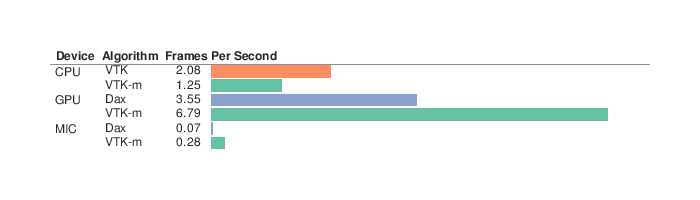

In [4]:
canvas = toyplot.Canvas(width=700, height=200)
table = canvas.table(data, columns=4)

# Generally I do not want vertical lines, but they can be handy when resizing columns.
#table.grid.vlines[...] = "single"

table.column(2).format = toyplot.format.FloatFormatter('{:.2f}')

table.column(0).width = 50
table.column(1).width = 60
table.column(2).width = 50

# We added an extra column when we created the table axes. Put a bar plot there.
axes = table.body.column(3).merge().axes(show=False, padding=1)
# In future versions of toyplot it will be easier to specify categorical colors
# using an array of categories.
colormap = toyplot.color.CategoricalMap()
colors = data['Algorithm'][::-1].replace({'VTK':1,
                                          'Dax':2,
                                          'VTK-m':0})
axes.bars(data['Frames Per Second'][::-1],
          along='y',
          color=(numpy.array(colors),colormap))

merged_cell = table.header.cell(0, 2, colspan=2).merge()
merged_cell.data = 'Frames Per Second'
merged_cell.align = 'left'

# The table rows are really in groups. I can express that in pandas with
# hierarchical indices, but I can't really directly specify that with
# toyplot (yet). Instead, fake it by merging cells of groups.
table_index = 0
for group_size in [2, 2, 2]:
    merged_cell = table.body.cell(table_index, 0, rowspan=group_size).merge()
    merged_cell.data = data['Device'].iloc[table_index]
    merged_cell.row_offset = -8.4*group_size + 10.8
    table_index += group_size

# This is to work around what appears to be an issue with how toyplot is currently
# scaling the y axis. For some reason it is insisting on scaling to 9, which is
# one half bar too far and making the bars not line up with the rows. This line
# fixes the problem. This should be fixed in future versions of toyplot.
axes.y.ticks.locator = toyplot.locator.Explicit([0,len(data.index)-1])

toyplot.pdf.render(canvas, 'VolumeRenderingTimes.pdf')

canvas